- check unique - some columns with only 1 value
- check collinearity - can drop 200 columns from this
- try models with feature_importances: decision tree and MARS
    - stick with predictors with highest importances
- PCA after removing collinear predictors?
- tune models: RF, MARS, logreg (maybe), AdaBoost, XGBoost
- Ensemble
- Colab for RF GridSearch

In [ ]:
print('hello world')

In [52]:
!python --version

Python 3.10.11


In [3]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 MB 16.7 MB/s eta 0:00:00


In [4]:
!pip install lightgbm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [1]:
!git clone --single-branch --branch v0.2dev https://github.com/scikit-learn-contrib/py-earth.git
%cd py-earth
!python setup.py install --cythonize

Cloning into 'py-earth'...
remote: Enumerating objects: 3303, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 3303 (delta 21), reused 17 (delta 17), pack-reused 3278
Receiving objects: 100% (3303/3303), 13.03 MiB | 28.70 MiB/s, done.
Resolving deltas: 100% (2505/2505), done.
/content/py-earth
Compiling pyearth/_basis.pyx because it depends on ./pyearth/_util.pxd.
Compiling pyearth/_record.pyx because it depends on ./pyearth/_util.pxd.
Compiling pyearth/_pruning.pyx because it depends on ./pyearth/_util.pxd.
Compiling pyearth/_forward.pyx because it changed.
Compiling pyearth/_knot_search.pyx because it changed.
Compiling pyearth/_qr.pyx because it depends on ./pyearth/_types.pxd.
[1/6] Cythonizing pyearth/_forward.pyx
/usr/local/lib/python3.10/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/py-ea

In [95]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.impute import KNNImputer
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import BaggingRegressor
import time
from pyearth import Earth

In [3]:
# Read the data
train = pd.read_csv('train.csv')
train.head()

,id,x001,x002,x003,x004,x005,x006,x007,x008,x009,...,x757,x758,x759,x760,x761,x762,x763,x764,x765,y
0,0,9.681860e+10,6991.15,7.76,0.00380,5.378811e+09,0.31,266117.20,934577.0,14539.0,...,0.0007,297281012,0.13,5.0,5,2.0,8.5127,14.28,-0.75,5
1,1,3.304810e+09,13914.43,5.37,0.00015,1.652405e+09,0.00,11927742.92,1798051.0,1051272.0,...,0.1136,3320000000000,0.08,661.0,0,350.0,1.5700,160.12,NaN,1
2,2,3.218944e+10,3991.98,5.77,0.00010,2.476111e+09,0.00,774385.01,375738.0,144143.0,...,0.0029,100474819,0.39,39.0,2,18.0,9.6800,25.06,-0.49,11
3,3,1.288000e+10,15937.45,5.86,0.00020,2.146667e+09,0.00,6324375.16,1932094.0,10055.0,...,0.0000,348000000000,0.25,2.0,1,0.0,4.5316,117.76,1.64,1
4,4,3.063412e+10,3621.00,7.52,0.00060,1.392460e+09,0.21,169860.29,474253.0,17914.0,...,0.0005,109546590,0.11,11.0,1,3.0,16.2717,5.81,-0.42,5


In [7]:
train.shape

(5380, 767)

In [ ]:
# check how many observations have missing values
train_dropna = train.dropna()
train_dropna.shape

(2857, 767)

Removing NAs almost halved the dataset. Two options:
- continue as usual. performance will probably suffer.
- imputation:
    - mean
    - lin reg prediction imputation?
    - k-NN imputation

In [4]:
X = train.drop(['id', 'y'], axis=1)
y = train['y']
X.shape

(5380, 765)

In [5]:
# perform k-nn imputation on missing values
imputer = KNNImputer(n_neighbors=7)
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)
print(X_imputed.shape)
print(X_imputed.isna().sum().sum())
X_imputed.head()

(5380, 765)
0


,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,...,x756,x757,x758,x759,x760,x761,x762,x763,x764,x765
0,9.681860e+10,6991.15,7.76,0.00380,5.378811e+09,0.31,266117.20,934577.0,14539.0,2.690000e+13,...,1.5707,0.0007,2.972810e+08,0.13,5.0,5.0,2.0,8.5127,14.28,-0.750000
1,3.304810e+09,13914.43,5.37,0.00015,1.652405e+09,0.00,11927742.92,1798051.0,1051272.0,1.690000e+17,...,0.1173,0.1136,3.320000e+12,0.08,661.0,0.0,350.0,1.5700,160.12,4.814286
2,3.218944e+10,3991.98,5.77,0.00010,2.476111e+09,0.00,774385.01,375738.0,144143.0,1.350000e+14,...,0.4582,0.0029,1.004748e+08,0.39,39.0,2.0,18.0,9.6800,25.06,-0.490000
3,1.288000e+10,15937.45,5.86,0.00020,2.146667e+09,0.00,6324375.16,1932094.0,10055.0,3.700000e+16,...,0.3816,0.0000,3.480000e+11,0.25,2.0,1.0,0.0,4.5316,117.76,1.640000
4,3.063412e+10,3621.00,7.52,0.00060,1.392460e+09,0.21,169860.29,474253.0,17914.0,6.000000e+12,...,0.0100,0.0005,1.095466e+08,0.11,11.0,1.0,3.0,16.2717,5.81,-0.420000


In [13]:
# identify variables with less than 8 unique values
cat_nonbin = []
for col in X_imputed.columns:
    if (len(X_imputed[col].unique()) < 8):
        print(col, '\n', X_imputed[col].unique())
        cat_nonbin.append(col)
print(len(cat_nonbin))

x025 
 [6. 2. 1. 5. 0. 3. 4.]
x063 
 [0.]
x137 
 [0.]
x255 
 [0.]
x385 
 [0.]
x405 
 [1.]
x453 
 [1.]
x465 
 [0.]
x516 
 [0. 1.]
x518 
 [0.]
x556 
 [1. 0.]
x594 
 [0.]
x643 
 [0.]
x703 
 [0.]
14


- 11 columns with only 1 value. Remove these since they cant be used for prediction if there is only 1 value among all instances.
- 2 binary and 1 categorical with 7 classes.

<Axes: xlabel='y', ylabel='Count'>

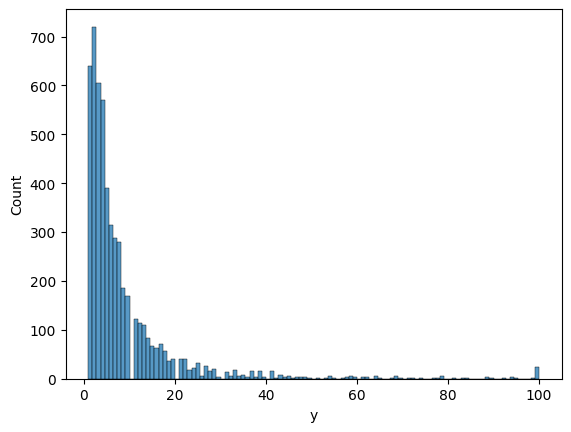

In [32]:
sns.histplot(y)

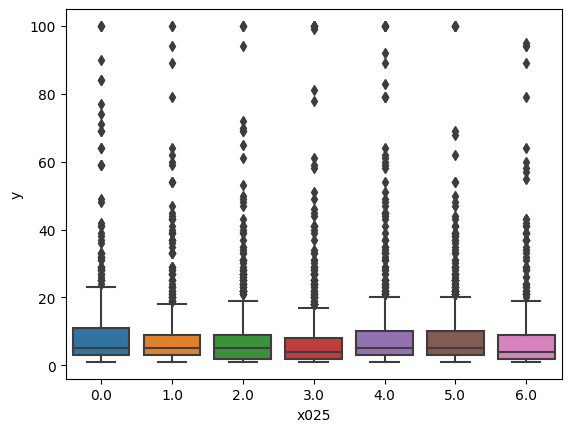

In [18]:
sns.boxplot(x = X_imputed.x025, y = y)
plt.show()

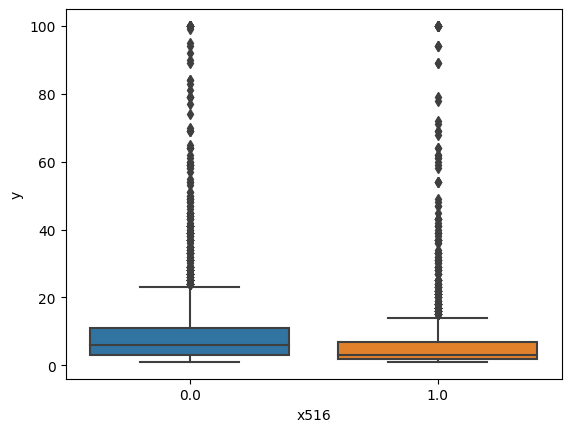

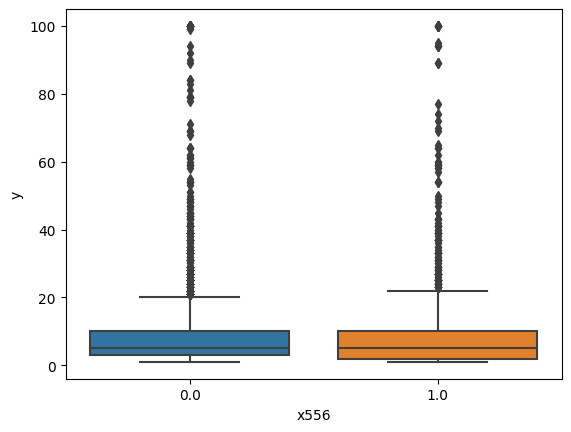

In [20]:
sns.boxplot(x = X_imputed.x516, y = y)
plt.show()
sns.boxplot(x = X_imputed.x556, y = y)
plt.show()

In [6]:
redundant = ['x063', 'x137', 'x255', 'x385', 'x405', 'x453', 'x465', 'x518', 'x594', 'x643', 'x703']
# redundant = []
# for col in cat_nonbin:
#     if (len(X_imputed[col].unique()) < 2):
#         redundant.append(col)
len(redundant)

11

In [7]:
X_imputed.drop(redundant, axis=1, inplace=True)
X_imputed.shape

(5380, 754)

## Multicollinearity

#### First check corr_matrix

In [8]:
corr_triu = np.triu(X_imputed.corr())
corr_triu

array([[ 1.        , -0.1032223 ,  0.1549608 , ...,  0.62700385,
        -0.15022717, -0.07129993],
       [ 0.        ,  1.        , -0.17774081, ...,  0.01797236,
         0.81943665, -0.01524231],
       [ 0.        ,  0.        ,  1.        , ...,  0.2040871 ,
        -0.50092743, -0.04305547],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
        -0.14165107, -0.09568018],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.        ,  0.0054187 ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.        ]])

In [9]:
print(len(np.sum(corr_triu > 0.95, axis = 1)))
corrs = np.sum(corr_triu > 0.95, axis = 1)
corrs

754


array([ 2, 13,  1,  3,  4,  1,  5, 12,  3,  1, 41, 21,  2,  1,  2,  9,  1,
        2,  4, 31, 46,  1,  2,  2,  1,  1,  1,  4, 66, 42,  2,  2, 57,  4,
        1,  1,  1, 44,  2, 63, 62, 10,  1,  1,  1,  4,  1,  1,  1,  1,  1,
        1,  1, 35, 41,  9, 12, 32,  1,  8,  1,  1,  1, 20, 25,  5,  1, 31,
        1, 19,  1,  4,  1,  1,  1,  1, 45,  1,  1,  1,  1,  5, 18,  1,  2,
       62,  7,  1,  1,  8,  2,  1, 14, 44,  1,  4,  1, 39,  3,  2,  2,  1,
       38,  1, 11, 56,  2,  4,  1,  1, 54,  8,  1,  3,  2,  6,  3,  1, 17,
        2,  2, 37,  1, 37, 53,  1,  2, 53, 28,  1,  1,  6,  5,  1,  1,  7,
       22, 36,  1,  1, 16, 36,  4,  1,  2, 34, 51,  1,  3, 29,  1,  4, 32,
       19, 11, 10, 55, 20,  1,  8,  1,  1,  1, 33,  1,  3,  1, 27,  7,  1,
        1,  2, 25, 30,  1,  1, 31, 10,  4, 15, 11, 39,  1,  1, 22,  1,  3,
        1,  1,  2,  3, 10,  1, 27,  3, 47,  8, 29,  1,  1,  7, 38,  3, 51,
        1,  1,  4, 50,  1,  2,  6, 32,  2, 10,  1, 49, 29,  8,  1, 27,  1,
       26,  4, 44,  4,  2

In [10]:
np.sum(corrs > 1)

384

In [12]:
col_corr = pd.DataFrame({'col': X_imputed.columns, 'corr': (corrs > 1)})
col_corr.head()

,col,corr
0,x001,True
1,x002,True
2,x003,False
3,x004,True
4,x005,True


drop columns where corr == True

In [ ]:
col_corr.dtypes

col     object
corr      bool
dtype: object

In [13]:
to_drop = col_corr[col_corr['corr'] == True]
len(to_drop)

384

In [14]:
to_drop = to_drop.col.tolist()

In [15]:
X_nocorr = X_imputed.drop(to_drop, axis = 1)

In [16]:
X_nocorr.shape

(5380, 370)

In [31]:
y_log = np.log(y)

### VIF (not used)

In [ ]:
# check multicollinearity

# the independent variables set
X = add_constant(X_imputed)

# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
						for i in range(len(X.columns))]

print(vif_data.shape)
print(vif_data[vif_data['VIF'] > 5].shape)
vif_data[vif_data['VIF'] > 5].sort_values(by = 'VIF', ascending = False)

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/linear_model.py:1752: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


(755, 2)


,feature,VIF
0,const,0.000000
1,x001,3.777547
2,x002,0.475717
3,x003,0.010762
4,x004,1.193601


goofed it up - need to start over from this point

In [ ]:
# remove the features with VIF > 5
# vif_features = vif_data[vif_data['VIF'] > 5]['feature'].values
# vif_features = ['x117', 'x181', 'x189', 'x193', 'x205', 'x238', 'x266', 'x320', 'x379', 'x407',
#  'x509', 'x667', 'x689', 'x700', 'x707']
# print(vif_features)
# X_imputed.drop(vif_features, axis=1, inplace=True)
# X_imputed.shape

['x117', 'x181', 'x189', 'x193', 'x205', 'x238', 'x266', 'x320', 'x379', 'x407', 'x509', 'x667', 'x689', 'x700', 'x707']


(5380, 739)

5380 obs, 739 features

## PCA (not used)

In [ ]:
# perform PCA on the remaining features
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99)
X_train_pca = pca.fit_transform(X_imputed)
X_train_pca.shape

(5380, 2)

In [ ]:
pca.explained_variance_ratio_

array([0.82618146, 0.17381854])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_train_pca, train['y'], test_size=0.2, random_state=42)

## Test Data

In [20]:
test = pd.read_csv('test.csv')
id = test['id']
test.drop(['id'], axis=1, inplace=True)
test_imputed = pd.DataFrame(imputer.transform(test), columns=test.columns)
test_imputed.drop(redundant, axis=1, inplace=True)
test_imputed.drop(to_drop, axis=1, inplace=True)
test_imputed.shape
# test_important = test_imputed.drop(unimportant, axis = 1)
# test_important.shape

(4403, 370)

## LGBMRegressor

In [ ]:
start_time = time.time()
lgbm = LGBMRegressor(random_state = 1)
param_grid = {'max_depth': [4,6,8],
              'num_leaves': [10, 20, 31, 40],
              'learning_rate': [0.01, 0.05, 0.1],
               'reg_lambda':[0, 10, 100],
                'n_estimators':[100, 400, 600],
                'reg_alpha': [0, 10, 100],
                'subsample': [0.4, 0.5, 0.6],
                'colsample_bytree': [0.5, 0.75, 1.0]}

cv = KFold(n_splits=3,shuffle=True,random_state=1)
grid = RandomizedSearchCV(estimator=LGBMRegressor(random_state=1),                                                       
                             param_distributions = param_grid, n_iter = 50,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv, scoring = 'neg_root_mean_squared_error',
                          random_state = 1)
grid.fit(X_nocorr, y)
print(grid.best_score_)
print(grid.best_params_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
-0.5021669905796237
{'subsample': 0.6, 'reg_lambda': 10, 'reg_alpha': 10, 'num_leaves': 40, 'n_estimators': 600, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.5}
Time taken =  1  minutes


first result: subsample 0.6, reg_lambda 10, reg_alpha 10, num_leaves 20, n_estimators 700, max_depth 6, learning rate 0.05, colsample_bytree 0.75

In [ ]:
importances = grid.best_estimator_.feature_importances_
importances = pd.DataFrame({'features': X_nocorr.columns, 'importances': importances})
importances.sort_values(by = 'importances', ascending = False)

,features,importances
317,x702,329
44,x105,287
138,x366,285
228,x567,248
46,x111,204
...,...,...
266,x630,0
224,x556,0
173,x452,0
31,x076,0


In [ ]:
unimportant = importances[importances['importances'] < 30]
unimportant = unimportant.features.tolist()
len(unimportant)

99

In [ ]:
X_important = X_nocorr.drop(unimportant, axis = 1)

In [ ]:
X_important.shape

(5380, 271)

In [ ]:
X_important.shape

(5380, 89)

## catboost select features
attempt using catboost select_features() to identify important features

In [40]:
from google.colab import output
output.enable_custom_widget_manager()

In [19]:
catboost_select = CatBoostRegressor(verbose = False, random_state = 0)
X_train, X_test, y_train, y_test = train_test_split(X_nocorr, y, test_size = 0.2, random_state = 0)
feat_importances = catboost_select.select_features(X_train, y_train, eval_set = (X_test, y_test), 
                                                   features_for_select = X_nocorr.columns, 
                                                   num_features_to_select = 50, 
                                                   steps = 3, plot = True, verbose = False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.064034
Step #1 out of 3

bestTest = 9.912136938
bestIteration = 950

Shrink model to first 951 iterations.
Feature #85 eliminated
Feature #99 eliminated
Feature #151 eliminated
Feature #135 eliminated
Feature #355 eliminated
Feature #122 eliminated
Feature #289 eliminated
Feature #86 eliminated
Feature #179 eliminated
Feature #100 eliminated
Feature #236 eliminated
Feature #215 eliminated
Feature #338 eliminated
Feature #107 eliminated
Feature #53 eliminated
Feature #183 eliminated
Feature #247 eliminated
Feature #149 eliminated
Feature #356 eliminated
Feature #295 eliminated
Feature #193 eliminated
Feature #364 eliminated
Feature #268 eliminated
Feature #19 eliminated
Feature #21 eliminated
Feature #16 eliminated
Feature #68 eliminated
Feature #181 eliminated
Feature #64 eliminated
Feature #130 eliminated
Feature #274 eliminated
Feature #70 eliminated
Feature #93 eliminated
Feature #210 eliminated
Feature #217 eliminated
Feature #156 eliminated
Feature #332 elim

In [36]:
len(feat_importances['selected_features'])

50

In [37]:
feat_importances.keys()

dict_keys(['selected_features', 'eliminated_features_names', 'loss_graph', 'eliminated_features', 'selected_features_names'])

In [18]:
X_cat_feats = X_nocorr.drop(feat_importances['eliminated_features_names'], axis = 1)
X_cat_feats.shape

(5380, 50)

In [24]:
catboost_select.fit(X_cat_feats, y)
test_cat_feats = test_imputed.drop(feat_importances['eliminated_features_names'], axis = 1)
y_pred_50 = catboost_select.predict(test_cat_feats)

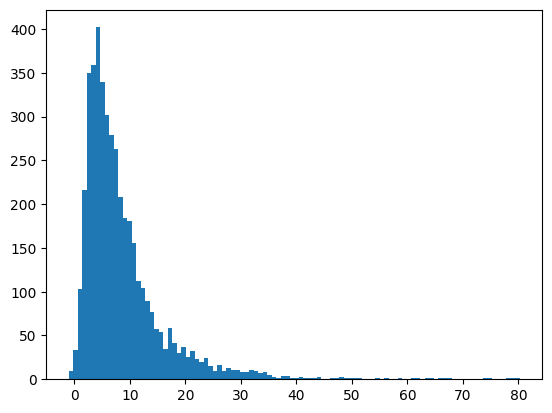

In [22]:
preds = pd.DataFrame({'id': id, 'y': y_pred_50})
plt.hist(preds['y'], bins=100)
plt.show()
preds.to_csv('catboost50.csv', index=False)

## MARS
to check residuals

In [73]:
mars = Earth(max_terms = 500, max_degree = 1)
mars.fit(X_cat_feats, y)
print(mars.summary())

Earth Model
---------------------------------------
Basis Function    Pruned  Coefficient  
---------------------------------------
(Intercept)       No      54.7653      
h(x10-2.75064)    Yes     None         
h(2.75064-x10)    No      -2.60796     
h(x21-3.71371)    No      93.7852      
h(3.71371-x21)    No      -2.29833     
h(x14+0.986158)   Yes     None         
h(-0.986158-x14)  No      5.93787      
h(x23-4.64479)    Yes     None         
h(4.64479-x23)    Yes     None         
h(x15+1.39856)    No      -3.9665      
h(-1.39856-x15)   Yes     None         
h(x41-3.64478)    No      -84.7043     
h(3.64478-x41)    No      -2.59309     
h(x26-1.32094)    Yes     None         
h(1.32094-x26)    Yes     None         
x44               No      1.43617      
x22               No      -2.31633     
h(x40+0.194773)   Yes     None         
h(-0.194773-x40)  No      79.8296      
h(x16-3.55526)    No      2.1374       
h(3.55526-x16)    No      -0.524319    
h(x49-2.51598)    No      -1

-9.586251660299463e-14


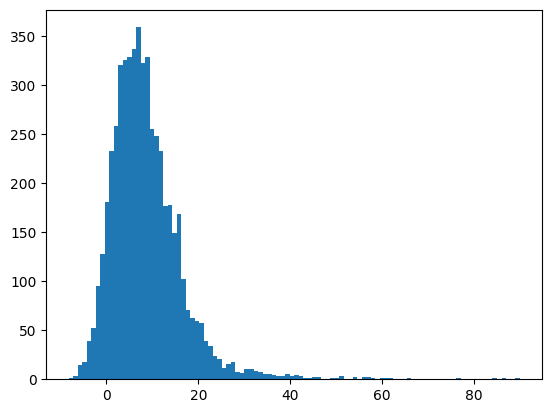

In [77]:
mars_preds = mars.predict(X_cat_feats)
resids = (mars_preds - y)
print(np.mean(resids))
plt.hist(mars_preds, bins = 100)
plt.show()

## CatBoost
#### after removing unimportant features

In [ ]:
catboost = CatBoostRegressor(verbose = False).fit(X_important, y_log)
y_pred = np.exp(catboost.predict(X_important))
# print('Test RMSE: ', np.sqrt(mean_squared_error(catboost.predict(X_test),y_test)))
print('Train RMSE: ', np.sqrt(mean_squared_error(y,y_pred)))

Train RMSE:  4.662234431103701


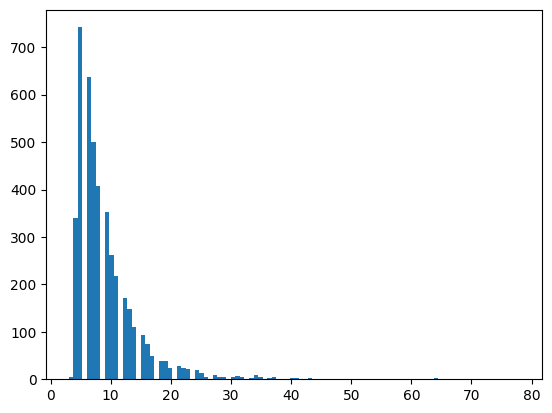

In [ ]:
y_pred_test = np.ceil(np.exp(catboost.predict(test_important)) + 2)
preds = pd.DataFrame({'id': id, 'y': y_pred_test})
preds.head()
plt.hist(preds['y'], bins=100)
plt.show()
preds.to_csv('preds_catboost_feat_log2plusceil.csv', index=False)

In [ ]:
catboost_feat_opt = CatBoostRegressor(verbose = False, subsample= 0.6, grow_policy = 'Lossguide',
                                      reg_lambda= 50, n_estimators= 800, max_leaves= 40, learning_rate= 0.08)
catboost_feat_opt.fit(X_important, y_log)
y_pred = np.exp(catboost.predict(X_important))
print('Train RMSE: ', np.sqrt(mean_squared_error(y,y_pred)))

Train RMSE:  4.662234431103701


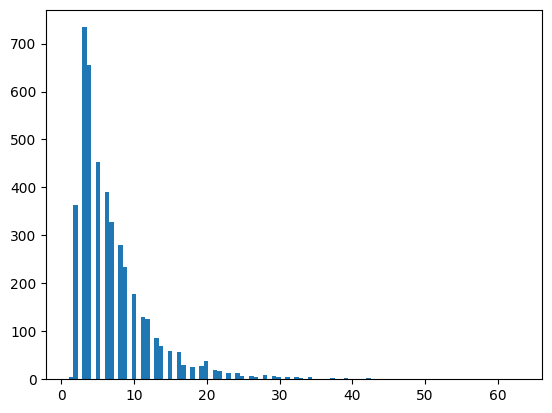

In [ ]:
y_pred_test = np.ceil(np.exp(catboost_feat_opt.predict(test_important)))
preds = pd.DataFrame({'id': id, 'y': y_pred_test})
preds.head()
plt.hist(preds['y'], bins=100)
plt.show()
preds.to_csv('preds_catboost_feat_opt_logceil.csv', index=False)

## CatBoost
#### without feat imp removed

In [ ]:
catboost = CatBoostRegressor(verbose = False).fit(X_nocorr, y_log)
y_pred = np.exp(catboost.predict(X_nocorr))
# print('Test RMSE: ', np.sqrt(mean_squared_error(catboost.predict(X_test),y_test)))
print('Train RMSE: ', np.sqrt(mean_squared_error(y,y_pred)))

Train RMSE:  4.716535820862308


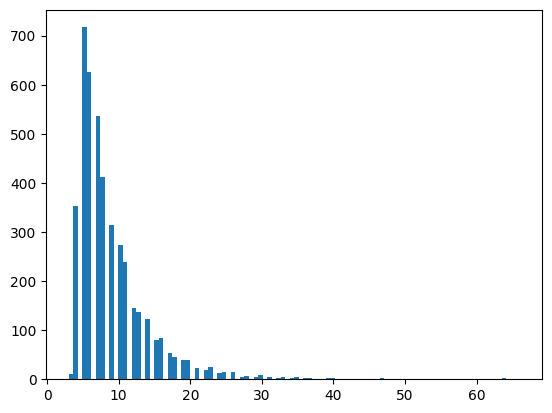

In [ ]:
y_pred_test = np.ceil(np.exp(catboost.predict(test_imputed)) + 2)
preds = pd.DataFrame({'id': id, 'y': y_pred_test})
preds.head()
plt.hist(preds['y'], bins=100)
plt.show()
preds.to_csv('preds_catboost_base_log2plus.csv', index=False)

In [ ]:
#K-fold cross validation to find optimal parameters for CatBoost regressor
start_time = time.time()
param_grid = {'max_depth': [4,8,12,16], # max allowed is 16
              'max_leaves': [20, 30, 40], # default 31
              'learning_rate': [0.01, 0.05, 0.1],
               'reg_lambda':[0, 10, 100],
                'n_estimators':[100, 500, 800],
                'subsample': [0.5, 0.7]}

cv = KFold(n_splits=3,shuffle=True,random_state=1)
catboost = CatBoostRegressor(random_state=1, verbose=False, 
                             grow_policy = 'Lossguide') # default uses RMSE for loss
grid_catboost = RandomizedSearchCV(estimator=catboost,                                                       
                             param_distributions = param_grid, n_iter = 20,
                             verbose = 1,random_state = 1, n_jobs=-1,
                             cv = cv, scoring = 'neg_mean_squared_error')
grid_catboost.fit(X_nocorr,y_log)
print("Optimal parameter values =", grid_catboost.best_params_)
print("Optimal cross validation MSE = ", grid_catboost.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Optimal parameter values = {'subsample': 0.5, 'reg_lambda': 10, 'n_estimators': 1000, 'max_leaves': 30, 'max_depth': 4, 'learning_rate': 0.1}
Optimal cross validation MSE =  -83.8623495283187
Time taken =  21  minutes


In [ ]:
# fine grid
start_time = time.time()
param_grid = {#'max_depth': [4,8,12,16], # max allowed is 16
              'max_leaves': [20, 30, 40], # default 31
              'learning_rate': [0.02, 0.05, 0.08],
               'reg_lambda':[5, 10, 50],
                'n_estimators':[400, 600, 800],
                'subsample': [0.4, 0.5, 0.6]}

cv = KFold(n_splits=3,shuffle=True,random_state=1)
catboost = CatBoostRegressor(random_state=1, verbose=False, 
                             grow_policy = 'Lossguide') # default uses RMSE for loss
grid_catboost = RandomizedSearchCV(estimator=catboost,                                                       
                             param_distributions = param_grid, n_iter = 5,
                             verbose = 1,random_state = 1, n_jobs=-1,
                             cv = cv, scoring = 'neg_mean_squared_error')
grid_catboost.fit(X_nocorr, y_log)
print("Optimal parameter values =", grid_catboost.best_params_)
print("Optimal cross validation MSE = ", grid_catboost.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Optimal parameter values = {'subsample': 0.6, 'reg_lambda': 50, 'n_estimators': 800, 'max_leaves': 40, 'learning_rate': 0.08}
Optimal cross validation MSE =  -0.48967742403979786
Time taken =  10  minutes


In [ ]:
np.sqrt(np.exp(grid_catboost.best_score_*-1))

1.277415264860953

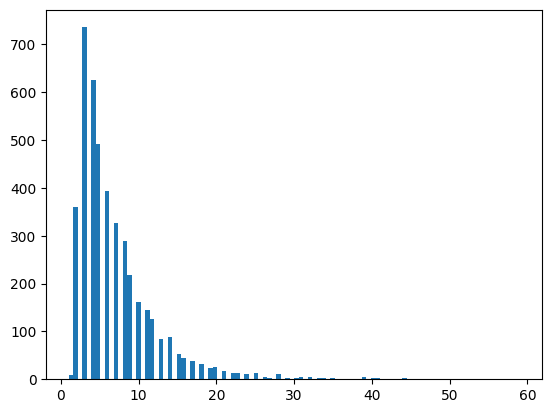

In [ ]:
y_pred_test = np.ceil(np.exp(grid_catboost.predict(test_imputed)))
preds = pd.DataFrame({'id': id, 'y': y_pred_test})
plt.hist(preds['y'], bins=100)
plt.show()

In [ ]:
preds.to_csv('preds_catboost_search6log_ceil.csv', index=False)

## quick test

In [ ]:
catboost_pred = pd.read_csv('preds_catboost_30important.csv')
catboost_pred.head()

,id,y
0,5380,3.744921
1,5381,8.477505
2,5382,4.453676
3,5383,9.181065
4,5384,5.315598


In [ ]:
catboost_pred['y'] = catboost_pred['y'].apply(lambda x : math.ceil(x + 2))
catboost_pred.head()

,id,y
0,5380,6
1,5381,11
2,5382,7
3,5383,12
4,5384,8


In [ ]:
catboost_pred.to_csv('preds_catboost_test.csv', index = False)

## XGBoost

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_important)
test_scaled = scaler.transform(test_important)

In [ ]:
xgb = XGBRegressor(random_state = 1).fit(X_scaled, y_log)
y_pred = np.exp(xgb.predict(X_scaled))
np.sqrt(mean_squared_error(y, y_pred))

1.9401822590132771

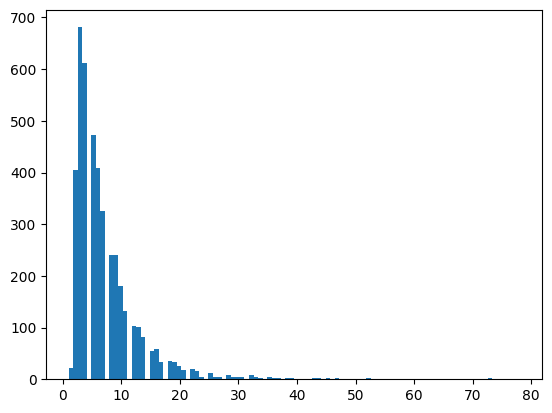

In [ ]:
y_pred_test = np.ceil(np.exp(xgb.predict(test_scaled)) + 2)
preds = pd.DataFrame({'id': id, 'y': y_pred_test})
plt.hist(preds['y'], bins=100)
plt.show()

In [ ]:
preds.to_csv('xgb_base_log_ceil.csv', index=False)

In [ ]:
xgb = XGBRegressor(random_state = 1)
start_time = time.time()
param_grid = {'max_depth': [4,6,8],
              'learning_rate': [0.01, 0.05, 0.1],
               'reg_lambda':[0, 1, 10],
                'n_estimators':[100, 400, 600],
                'gamma': [0, 10, 100],
                'subsample': [0.5, 0.7],
                'colsample_bytree': [0.5, 0.75, 1.0]}

cv = KFold(n_splits=3,shuffle=True,random_state=1)
optimal_params = RandomizedSearchCV(estimator=XGBRegressor(random_state = 1),                                                       
                             param_distributions = param_grid, n_iter = 50,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv, random_state = 1)
optimal_params.fit(X_scaled,y_log)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross validation R-squared = ",optimal_params.best_score_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Optimal parameter values = {'subsample': 0.7, 'reg_lambda': 1, 'n_estimators': 600, 'max_depth': 6, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 1.0}
Optimal cross validation R-squared =  0.4896251952251694
Time taken =  7  minutes


In [ ]:
y_pred = np.exp(optimal_params.predict(X_scaled))
np.sqrt(mean_squared_error(y, y_pred))

6.535569956397642

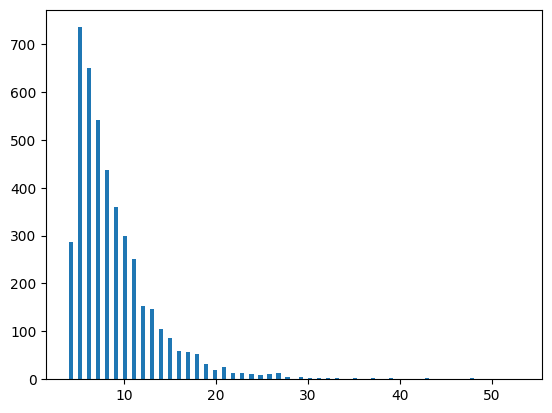

In [ ]:
y_pred_test = np.ceil(np.exp(optimal_params.predict(test_scaled)) + 2)
preds = pd.DataFrame({'id': id, 'y': y_pred_test})
plt.hist(preds['y'], bins=100)
plt.show()

In [ ]:
preds.to_csv('xgb_tuned_log_ceil_2plus.csv', index=False)

## LGBM with important features


In [115]:
start_time = time.time()
lgbm = LGBMRegressor(random_state = 1)
param_grid = {'max_depth': [4,6,8],
              'num_leaves': [10, 20, 31, 40],
              'learning_rate': [0.01, 0.02, 0.05],
               'reg_lambda':[0, 10, 100],
                'n_estimators':[100, 400, 600],
                'reg_alpha': [0, 10, 100],
                'subsample': [0.4, 0.5, 0.6],
                'colsample_bytree': [0.5, 0.75, 1.0]}

cv = KFold(n_splits=3,shuffle=True,random_state=1)
grid = RandomizedSearchCV(estimator=LGBMRegressor(random_state=1),                                                       
                             param_distributions = param_grid, 
                            n_iter = 500,
                             verbose = 1,
                             n_jobs=-1,
                             cv = cv, scoring = 'neg_root_mean_squared_error',
                          random_state = 0
                    )
grid.fit(X_cat_feats, y_log)
print(grid.best_score_)
print(grid.best_params_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
-0.6982445738726533
{'subsample': 0.5, 'reg_lambda': 10, 'reg_alpha': 0, 'num_leaves': 20, 'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.05, 'colsample_bytree': 0.5}
Time taken =  1  minutes


## Bagged Catboost

In [96]:
cat = CatBoostRegressor(verbose = False, random_state = 0)
cat_bag = BaggingRegressor(estimator = cat, max_samples = 0.75,
                           random_state = 0,
                           verbose = 1, n_jobs = -1)

## Ensemble

In [59]:
from sklearn.ensemble import VotingRegressor, VotingClassifier, StackingRegressor, StackingClassifier, GradientBoostingRegressor,GradientBoostingClassifier, BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier,AdaBoostRegressor,AdaBoostClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression, LassoCV, RidgeCV, ElasticNetCV

In [116]:
catboost = CatBoostRegressor(random_state = 0, verbose = False)
xgb = XGBRegressor(random_state = 0, subsample = 0.7, reg_lambda = 1,
                   n_estimators = 600, max_depth = 6, learning_rate = 0.01)
lgbm = LGBMRegressor(random_state = 0, subsample = 0.5, reg_lambda = 10,
                     reg_alpha = 0, num_leaves = 20, n_estimators = 400,
                     max_depth = 6, learning_rate = 0.05, 
                     colsample_bytree = 0.5)

In [69]:
scaler = StandardScaler()
X_cat_scaled = scaler.fit_transform(X_cat_feats)
test_cat_scaled = scaler.transform(test_cat_feats)

In [79]:
y_log = np.log(y)

In [117]:
#Stacking using LinearRegression as the metamodel
start_time = time.time()
en = StackingRegressor(estimators = [('catboost', catboost),('xgb', xgb), ('lgbm', lgbm), ('cat_bag', cat_bag), ('mars', mars)],
                     final_estimator=LinearRegression(),                                          
                    cv = KFold(n_splits = 5, shuffle = True, random_state=1))
en.fit(X_cat_scaled,y_log)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   53.2s remaining:  3.5min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   54.3s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   51.5s remaining:  3.4min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   52.9s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:   51.3s remaining:  3.4min
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:   52.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parall

StackingRegressor(cv=KFold(n_splits=5, random_state=1, shuffle=True),
                  estimators=[('catboost',
                               <catboost.core.CatBoostRegressor object at 0x7fef944caef0>),
                              ('xgb',
                               XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            fe...
                               LGBMRegressor(colsample_bytree=0.5,
                                             learning_rate=0.05, max_depth=6,
                                             n_estimators=400, num_leaves=20,
                                             random_state=0, reg_alpha=0,
                                             reg_lambda=10, subsample=0.5)),
                              ('cat_bag',
                               BaggingRegressor(estimator=<catboost.core.CatBoostRegressor object at 0x7fef9446e830>,
                                                max_samples=0.75, n_jobs=-1,
                                                random_state=0, verbose=1)),
                              ('mars', Earth(max_degree=1, max_terms=500))],
                  final_estimator=LinearRegression())

In [ ]:
print("Linear regression metamodel RMSE = ", np.sqrt(mean_squared_error(np.exp(en.predict(X_scaled)),y)))

Linear regression metamodel RMSE =  4.103300532713369


In [118]:
print("Linear regression metamodel RMSE = ", np.sqrt(mean_squared_error(np.exp(en.predict(X_cat_scaled)),y)))

Linear regression metamodel RMSE =  6.939083291913043


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.1s finished


In [119]:
resids = np.exp(en.predict(X_cat_scaled)) - y
add_resid = np.mean(resids)
add_resid

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.1s finished


-1.590435273716512

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of  10 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=10)]: Done  10 out of  10 | elapsed:    0.1s finished


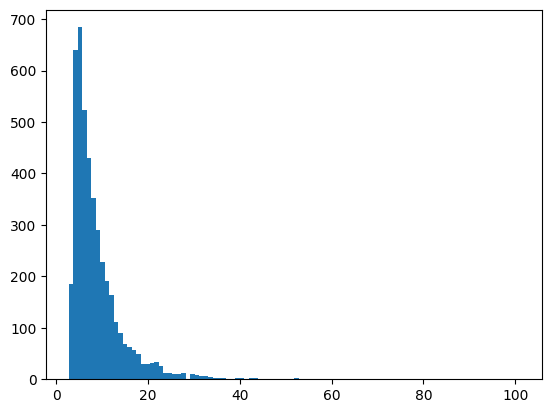

In [120]:
y_pred_test = np.exp(en.predict(test_cat_scaled)) + 2
# y_pred_test = np.exp(en.predict(test_cat_feats))
preds = pd.DataFrame({'id': id, 'y': y_pred_test})
plt.hist(preds['y'], bins=100)
plt.show()

In [121]:
preds.to_csv('ensemble4_log_2.csv', index=False)

## Random Forest

In [ ]:

rf = RandomForestRegressor(n_jobs = -1, random_state = 1)
rf.fit(X_train,y_train)
y_pred = rf.predict(X_test)
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
# check train RMSE
y_pred_train = rf.predict(X_train)
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)))

Test RMSE: 12.161859112738298
Train RMSE: 7.129311893531426


In [ ]:
rf.n_estimators

100

base model overfits

In [ ]:
start_time = time.time()
rf = RandomForestRegressor(n_jobs = -1, random_state = 1)
params = {'n_estimators':[200,400,600], 'max_depth':range(5,20,5), 
          'max_features':[0.4,0.6], 'max_leaf_nodes':[1000,2000,4000], 
          'bootstrap': [True, False]}
kfold = KFold(3, shuffle = True, random_state = 1)
grid = RandomizedSearchCV(rf, params, cv = kfold, verbose = 10, 
                    n_jobs = -1, scoring = 'neg_mean_squared_error',
                    n_iter = 20)
grid.fit(X_scaled, y_log)
print(grid.best_score_)
print(grid.best_params_)
print("Time taken = ", round((time.time()-start_time)/60), " minutes")

Fitting 3 folds for each of 20 candidates, totalling 60 fits
-0.561504036422474
{'n_estimators': 600, 'max_leaf_nodes': 1000, 'max_features': 0.6, 'max_depth': 15, 'bootstrap': True}
Time taken =  7  minutes


In [ ]:
y_pred = grid.predict(X_scaled)
print('Test RMSE:', np.sqrt(mean_squared_error(y, np.exp(y_pred))))
# check train RMSE
# y_pred_train = grid.predict(X_train)
# print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)))

Test RMSE: 5.915833046723344


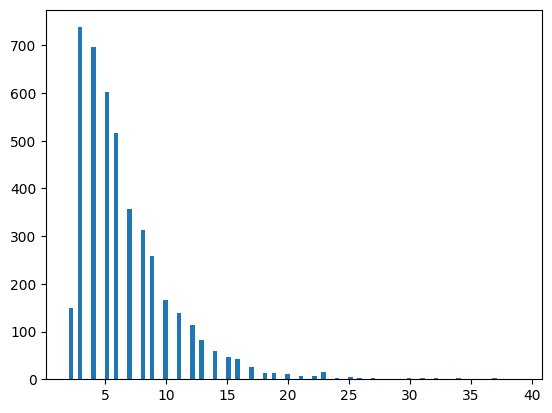

In [ ]:
y_pred_test = np.ceil(np.exp(grid.predict(test_scaled)))
preds = pd.DataFrame({'id': id, 'y': y_pred_test})
plt.hist(preds['y'], bins=100)
plt.show()

In [ ]:
preds.to_csv('rf1_log_ceil.csv', index=False)

In [ ]:
params = {'n_estimators':[200,400,600,800], 'max_depth':range(2,12,2), 
          'max_features':[1,2], 'max_leaf_nodes':[600,800,1000,1200,1400], 
          'bootstrap': [True]}
kfold = KFold(4, shuffle = True, random_state = 42)
grid = GridSearchCV(rf, params, cv = kfold, verbose = 1, n_jobs = -1, scoring = 'neg_mean_squared_error')
grid.fit(X_train, y_train)
print(grid.best_score_)
grid.best_params_

Fitting 4 folds for each of 200 candidates, totalling 800 fits
-145.44762610384223


{'bootstrap': True,
 'max_depth': 2,
 'max_features': 1,
 'max_leaf_nodes': 600,
 'n_estimators': 200}

In [ ]:
y_pred = grid.predict(X_test)
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
# check train RMSE
y_pred_train = grid.predict(X_train)
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)))

Test RMSE: 10.944036965764708
Train RMSE: 12.001448822742411


In [ ]:
test = pd.read_csv('test.csv')
id = test['id']
test.drop(['id'], axis=1, inplace=True)
test_imputed = pd.DataFrame(imputer.transform(test), columns=test.columns)
test_imputed.drop(redundant, axis=1, inplace=True)
test_imputed.drop(vif_features, axis=1, inplace=True)
test_imputed.shape

(4403, 739)

In [ ]:
test_pca = pca.transform(test_imputed)
print(test_pca.shape)
y_pred_test = grid.predict(test_pca)
preds = pd.DataFrame({'id': id, 'y': y_pred_test})
preds.head()

(4403, 2)


,id,y
0,5380,10.706960
1,5381,10.688578
2,5382,11.120407
3,5383,11.099542
4,5384,7.720696


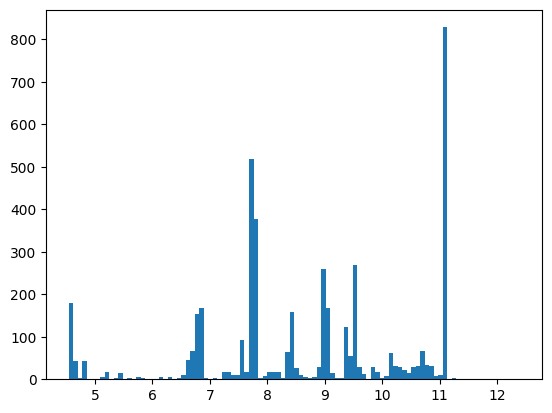

In [ ]:
plt.hist(preds['y'], bins=100)
plt.show()

In [ ]:
preds.to_csv('preds.csv', index=False)

## Lin Reg

In [ ]:
# train linear regression model with PCA features
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(train_pca, train['y'], test_size=0.2, random_state=42)
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print('Test RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))
# check train RMSE
y_pred_train = linreg.predict(X_train)
print('Train RMSE:', np.sqrt(mean_squared_error(y_train, y_pred_train)))

Test RMSE: 11.11049207014291
Train RMSE: 12.216774597268362


In [ ]:
test = pd.read_csv('test.csv')
test.head()

,id,x001,x002,x003,x004,x005,x006,x007,x008,x009,...,x756,x757,x758,x759,x760,x761,x762,x763,x764,x765
0,5380,6.507826e+10,7882.15,6.82,0.00210,1.712586e+09,0.39,583617.74,862986.0,63872.0,...,0.0380,0.0010,90204869909,0.26,8.0,5,5.0,30.1213,27.95,-0.49
1,5381,3.122741e+09,4682.13,8.17,0.00010,1.040914e+09,0.00,190000.65,688710.0,35407.0,...,0.1866,0.0192,37449565014,0.02,16.0,1,8.0,2.1282,10.18,0.55
2,5382,3.888719e+10,7495.57,7.15,0.00285,2.160400e+09,0.42,351570.67,841523.0,170240.0,...,0.0100,0.0017,10847937619,0.83,35.0,1,19.0,7.8513,21.27,19.09
3,5383,7.727427e+10,4003.76,6.53,0.00165,5.519591e+09,0.00,320216.05,466131.0,35.0,...,0.4636,0.0000,37200096,0.51,1.0,4,0.0,9.0511,18.38,4.11
4,5384,4.184868e+09,34874.72,6.39,0.00065,1.046217e+09,0.50,3349978.53,3711028.0,1757.0,...,2.8737,0.0001,16400000000000,0.12,2.0,1,2.0,2.6512,149.68,0.02


In [ ]:
id = test['id']
test.drop(['id'], axis=1, inplace=True)
test_imputed = pd.DataFrame(imputer.transform(test), columns=test.columns)
print(test_imputed.shape)
print(test_imputed.isna().sum().sum())
test_imputed.head()

(4403, 765)
0


,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,...,x756,x757,x758,x759,x760,x761,x762,x763,x764,x765
0,6.507826e+10,7882.15,6.82,0.00210,1.712586e+09,0.39,583617.74,862986.0,63872.0,1.470000e+14,...,0.0380,0.0010,9.020487e+10,0.26,8.0,5.0,5.0,30.1213,27.95,-0.49
1,3.122741e+09,4682.13,8.17,0.00010,1.040914e+09,0.00,190000.65,688710.0,35407.0,1.130000e+13,...,0.1866,0.0192,3.744957e+10,0.02,16.0,1.0,8.0,2.1282,10.18,0.55
2,3.888719e+10,7495.57,7.15,0.00285,2.160400e+09,0.42,351570.67,841523.0,170240.0,4.140000e+13,...,0.0100,0.0017,1.084794e+10,0.83,35.0,1.0,19.0,7.8513,21.27,19.09
3,7.727427e+10,4003.76,6.53,0.00165,5.519591e+09,0.00,320216.05,466131.0,35.0,2.080000e+13,...,0.4636,0.0000,3.720010e+07,0.51,1.0,4.0,0.0,9.0511,18.38,4.11
4,4.184868e+09,34874.72,6.39,0.00065,1.046217e+09,0.50,3349978.53,3711028.0,1757.0,2.110000e+16,...,2.8737,0.0001,1.640000e+13,0.12,2.0,1.0,2.0,2.6512,149.68,0.02


In [ ]:
# drop redundant and multicollinear features
test_imputed.drop(redundant, axis=1, inplace=True)
test_imputed.drop(vif_features, axis=1, inplace=True)
test_imputed.shape

(4403, 739)

In [ ]:
# pca on test data
test_pca = pca.transform(test_imputed)
test_pca.shape

(4403, 2)

In [ ]:
# predict on test data
y_pred_test = linreg.predict(test_pca)
y_pred_test

array([8.76397649, 8.76397623, 8.76397665, ..., 8.76397332, 8.76334354,
       8.7160544 ])

In [ ]:
# preds dataframe
preds = pd.DataFrame({'id': id, 'y': y_pred_test})
preds.head()

,id,y
0,5380,8.763976
1,5381,8.763976
2,5382,8.763977
3,5383,8.763977
4,5384,8.763015


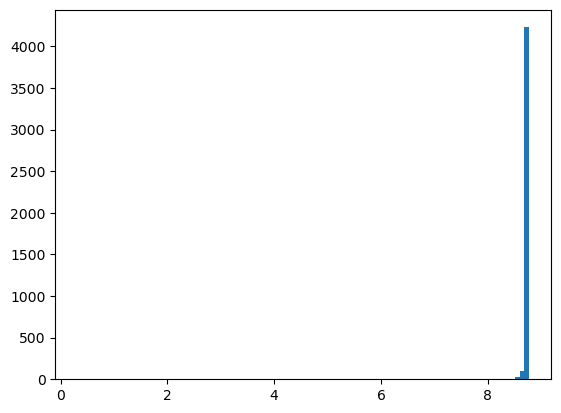

In [ ]:
# distribution of predictions
plt.hist(preds['y'], bins=100)
plt.show()

In [ ]:
preds.to_csv('preds.csv', index=False)

## Neural Net try

In [23]:
from keras.models import Sequential
from keras.layers import InputLayer, Dense, Dropout
from keras.utils import to_categorical, set_random_seed
from keras.callbacks import EarlyStopping

In [25]:
scaler = StandardScaler()
X_cat_feats = scaler.fit_transform(X_cat_feats)
test_cat_feats = scaler.transform(test_cat_feats)

In [47]:
scaler = StandardScaler()
X_nocorr = scaler.fit_transform(X_nocorr)
test_nocorr = scaler.transform(test_imputed)
X_nocorr.shape

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning:

X has feature names, but StandardScaler was fitted without feature names



(5380, 370)

In [53]:
y

0        5
1        1
2       11
3        1
4        5
        ..
5375     4
5376     8
5377    21
5378    13
5379    28
Name: y, Length: 5380, dtype: int64

In [54]:
network = Sequential()
network.add(InputLayer(input_shape=(370,)))
network.add(Dropout(0.2))
network.add(Dense(500, activation='relu', kernel_initializer='HeNormal'))
network.add(Dropout(0.2))
network.add(Dense(200, activation='relu', kernel_initializer='HeNormal'))
network.add(Dropout(0.2))
network.add(Dense(100, activation='relu', kernel_initializer='HeNormal'))
network.add(Dropout(0.2))
network.add(Dense(50, activation='relu', kernel_initializer='HeNormal'))
network.add(Dropout(0.2))
network.add(Dense(20, activation='relu', kernel_initializer='HeNormal'))
network.add(Dropout(0.2))
network.add(Dense(10, activation='relu', kernel_initializer='HeNormal'))
network.add(Dropout(0.2))
network.add(Dense(5, activation='relu', kernel_initializer='HeNormal'))
network.add(Dense(1, activation = 'linear', kernel_initializer='HeNormal'))

network.compile(loss = 'mean_squared_error', optimizer = 'adam')
print(network.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_22 (Dropout)        (None, 370)               0         
                                                                 
 dense_26 (Dense)            (None, 500)               185500    
                                                                 
 dropout_23 (Dropout)        (None, 500)               0         
                                                                 
 dense_27 (Dense)            (None, 200)               100200    
                                                                 
 dropout_24 (Dropout)        (None, 200)               0         
                                                                 
 dense_28 (Dense)            (None, 100)               20100     
                                                                 
 dropout_25 (Dropout)        (None, 100)              

In [57]:
set_random_seed(0)
early = EarlyStopping(monitor='val_loss', patience=5)
history = network.fit(X_nocorr, y, epochs = 200, batch_size = 100, validation_split = 0.1, callbacks = early)

Epoch 1/200
49/49 [==============================] - 1s 8ms/step - loss: 58.4174 - val_loss: 122.4995
Epoch 2/200
49/49 [==============================] - 0s 7ms/step - loss: 55.8920 - val_loss: 123.1124
Epoch 3/200
49/49 [==============================] - 0s 7ms/step - loss: 56.8570 - val_loss: 109.0244
Epoch 4/200
49/49 [==============================] - 0s 7ms/step - loss: 53.9295 - val_loss: 123.0547
Epoch 5/200
49/49 [==============================] - 0s 7ms/step - loss: 52.2289 - val_loss: 116.1121
Epoch 6/200
49/49 [==============================] - 0s 6ms/step - loss: 50.6799 - val_loss: 111.4739
Epoch 7/200
49/49 [==============================] - 0s 6ms/step - loss: 49.9487 - val_loss: 114.4016
Epoch 8/200
49/49 [==============================] - 0s 6ms/step - loss: 42.2824 - val_loss: 114.9462


dict_keys(['loss', 'val_loss'])


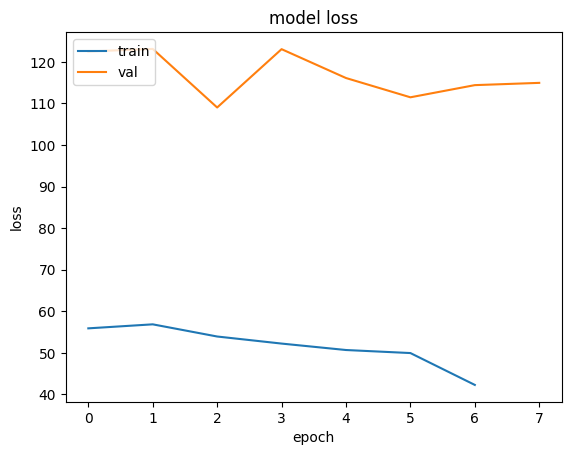

In [58]:
print(history.history.keys())
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [44]:
# y_pred_net = network.predict(test_cat_feats)
y_pred_net = list(network.predict(test_cat_feats).flatten())

138/138 [==============================] - 0s 1ms/step


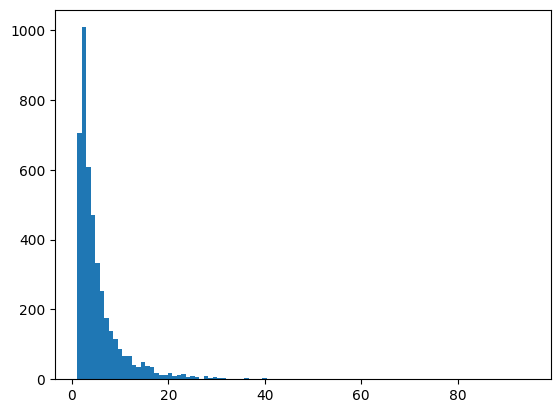

In [45]:
preds = pd.DataFrame({'id': id, 'y': y_pred_net})
plt.hist(preds['y'], bins=100)
plt.show()

In [46]:
preds.to_csv('network1_test.csv', index = False)